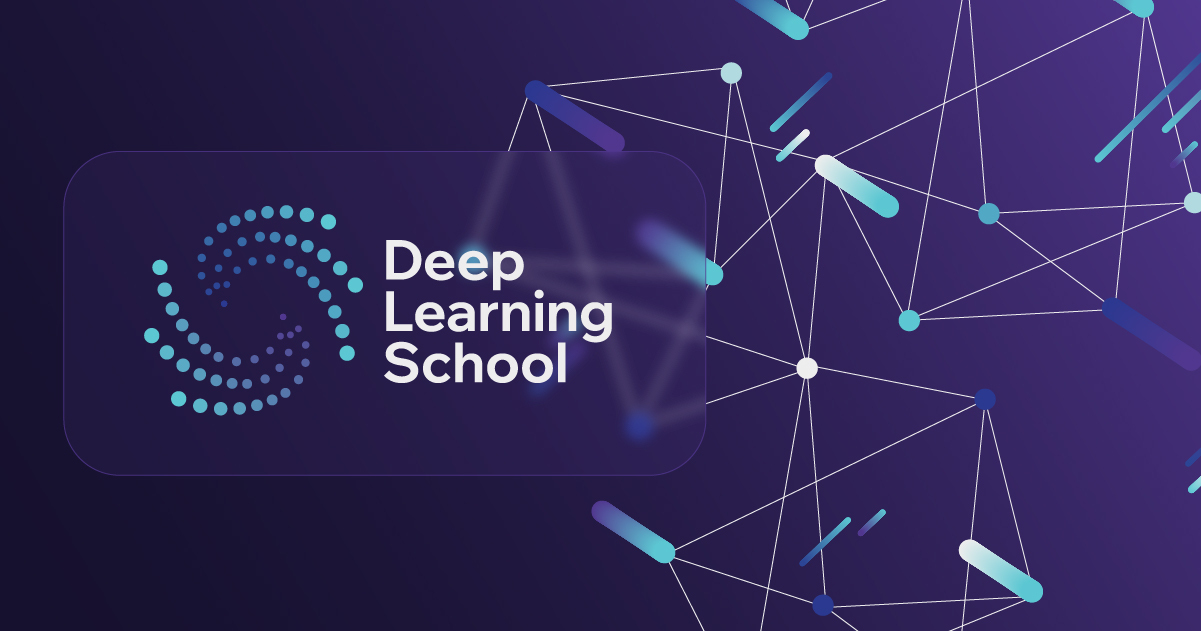

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

<h2 style="text-align: center;"><b>Семинар. PyTorch. Батчнорм и дропаут. </b></h2>


Работаем с датасетом CIFAR и обучаем CNN, рассмотрим батчнорм, а также особенности батчнорма для CNN. Далее применим дропаут

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

sns.set(font_scale=1.4, style="whitegrid")

In [ ]:
# Зафиксируем сиды для воспроизводимости
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# Выберем cuda или cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Загрузка датасета

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) — это набор данных, состоящий из 60 000 цветных изображений размером $32 \times 32$ пикселя, разделённых на 10 классов (например, самолёты, автомобили, птицы, кошки и др.). Из них 50 000 изображений используются для обучения моделей, а 10 000 — для их тестирования. Этот датасет широко применяется в задачах компьютерного зрения и отлично подходит для экспериментов с PyTorch.


In [ ]:
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root="./data", train=False,
                                           download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

В PyTorch датасетом считается любой объект, для которого определены методы `__len__(self)` и `__getitem__(self, i)`.

DataLoader превращает датасет в батчи, есть перемешивание, а также он может распараллелить загрузку

# Код обучения

In [ ]:
def train_one_epoch(model, loss_func, optimizer, train_dl):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): Model to be trained.
        loss_func (callable): Loss function.
        optimizer (torch.optim.Optimizer): Optimization algorithm.
        train_dl (DataLoader): Dataloader for the training set.

    Returns:
        float: Average training loss over the entire epoch.
    """
    model.train()  # Set model to training mode
    total_loss = 0.0    # лосс по эпохе

    for xb, yb in tqdm(train_dl, desc="Training"):
        # Move data to the appropriate device
        xb, yb = xb.to(device), yb.to(device)

        # Forward pass
        preds = model(xb)
        loss = loss_func(preds, yb)

        # Accumulate loss
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Return the average loss
    return total_loss / len(train_dl)


def validate(model, loss_func, valid_dl):
    """
    Validate the model on a given validation set.

    Args:
        model (torch.nn.Module): Model to be validated.
        loss_func (callable): Loss function.
        valid_dl (DataLoader): Dataloader for the validation set.

    Returns:
        float: Average validation loss over the entire validation set.
        float: Accuracy of the model on the validation set (0 to 1).
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # for validation we don't need calculate gradients
    # ! eval() mode doesn't turn off gradients !
    with torch.no_grad():
        for xb, yb in tqdm(valid_dl, desc="Validation"):
            # Move data to the appropriate device
            xb, yb = xb.to(device), yb.to(device)

            # Forward pass
            preds = model(xb)
            loss = loss_func(preds, yb)
            total_loss += loss.item()

            # Compute accuracy

            # находит max значение среди preds, выводит max вероятность и индекс класса
            _, predicted_labels = torch.max(preds, dim=-1)
            total_correct += (predicted_labels == yb).sum().item()
            total_samples += xb.size(0)

    avg_loss = total_loss / len(valid_dl)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    """
    Train and validate a model over a specified number of epochs.

    Args:
        epochs (int): Number of epochs to train.
        model (torch.nn.Module): Model to be trained and validated.
        loss_func (callable): Loss function (e.g., nn.CrossEntropyLoss()).
        optimizer (torch.optim.Optimizer): Optimization algorithm (e.g., SGD).
        train_dl (DataLoader): Dataloader for the training set.
        valid_dl (DataLoader): Dataloader for the validation set.

    Returns:
        tuple:
            - train_losses (list of float): Average training losses per epoch.
            - val_losses (list of float): Average validation losses per epoch.
            - valid_accuracies (list of float): Validation accuracies per epoch.
    """
    train_losses = [] # список лоссов всех эпох
    val_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train for one epoch
        train_loss = train_one_epoch(model, loss_func, optimizer, train_dl)

        # Validate after the epoch
        val_loss, val_acc = validate(model, loss_func, valid_dl)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        # Print a summary for quick reference
        print(f"Epoch {epoch+1} -> "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, valid_accuracies

In [ ]:
def plot_training(train_losses, valid_losses, valid_accuracies):
    """
    Plots training and validation losses, and validation accuracy over epochs.
    """
    plt.figure(figsize=(12, 9))

    # Plot training and validation losses in the first subplot
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()

    # Plot validation accuracy in the second subplot
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Далее мы запускаем обучение модели:
- Определяем функцию потерь ([CrossEntropyLoss](https://colab.research.google.com/drive/1EOlgKwXSj9z7JqBl9sz2Xg-pfv2Xjw7e#scrollTo=RQygJ0ZHCgCK&line=2&uniqifier=1)) и оптимизатор ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) с параметрами $\text{lr}=0.001$ и $\text{momentum}=0.9$).
- Запускаем обучение модели на $10$ эпох с помощью функции `fit` и визуализируем результаты (графики потерь и точности) с помощью plot_training.

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s]



Epoch 1/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.7264 | Val Loss: 1.3676 | Val Acc: 0.5030

Epoch 2/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.3052 | Val Loss: 1.2284 | Val Acc: 0.5668

Epoch 3/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 1.1315 | Val Loss: 1.1040 | Val Acc: 0.6145

Epoch 4/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 1.0137 | Val Loss: 1.0476 | Val Acc: 0.6385

Epoch 5/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.9302 | Val Loss: 1.0179 | Val Acc: 0.6490

Epoch 6/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.8650 | Val Loss: 1.0241 | Val Acc: 0.6513

Epoch 7/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.8075 | Val Loss: 1.0169 | Val Acc: 0.6586

Epoch 8/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.7589 | Val Loss: 1.0287 | Val Acc: 0.6542

Epoch 9/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.7163 | Val Loss: 1.0628 | Val Acc: 0.6539

Epoch 10/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.6745 | Val Loss: 1.0944 | Val Acc: 0.6596


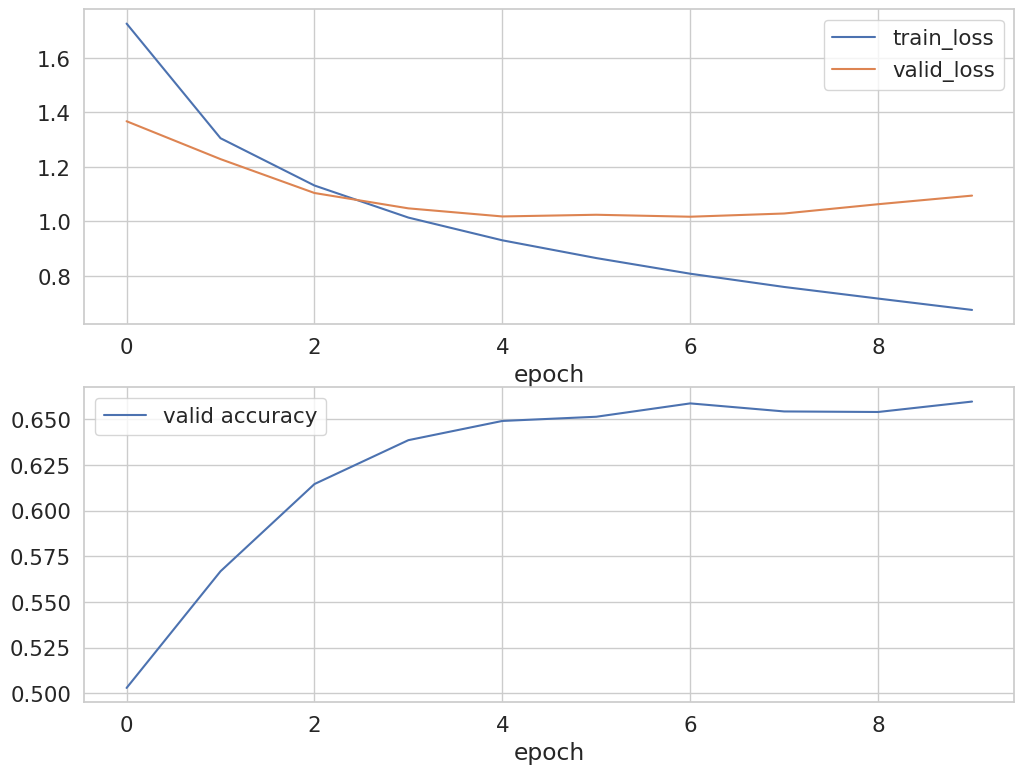

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_training(*info)

Лосс: 1.0944

Accuracy: 0.6596

# BatchNorm
Ранее мы обсуждали, что для линейных моделей очень важно нормировать признаки перед подачей на вход. Когда мы работаем с нейронными сетями мы тоже нормируем вход, но есть ли какой-то способ нормировать признаки на внутренних слоях нейроной сети?

Да, существует несколько метдов нормировки признаков (BatchNorm, LayerNorm, InstanceNorm, etc). Научимся применять BatchNorm.


### BatchNorm, математика

Если коротко, то `BatchNorm` для каждого признака вычитает среднее значение по батчу и делит на стандартное отклонение по батчу, потом домножает все признаки на вес $\gamma$ и прибавляет вес $\beta$. При этом возникает вопрос, что если мы используем модель уже для предсказаний и можем запускать ее только на одном примере.

`BatchNorm` работает по разному во время обучения и предсказаний:


**Во время обучения**. Пусть батч состоит из $\mathbf{x_i}$ (каждый $\mathbf{x_i}$ - вектор, подающийся на вход). Тогда
$$\begin{aligned}
\mu_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{\mathcal{B}}^{2} & \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2} \\
\widehat{x}_{i} & \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \\
y_{i} & \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{B} \mathrm{N}_{\gamma, \beta}\left(x_{i}\right)
\end{aligned}$$

**Во время предсказания**. Мы делаем то же самое, но у нас нет батча. Поэтому в качестве $\mu_{\mathcal{B}}$ и $\sigma_{\mathcal{B}}$ мы используем среднее и стандартное отклонение признака во всем датасете. Обычно нам не хочется после обучения еще раз применять сеть ко всем примерам из обучающего датасета, чтобы вычислить эти статистики и мы вместо них используем экспоненциально затухающее среднее последних батчей (храним внутри слоя).



Экспоненциальное скользящее среднее (веса убывают экспонециально):

$$\textit{EMA}_{t}=\alpha \cdot p_{t}+(1-\alpha )\cdot \textit{EMA}_{t-1},$$

где

$\textit{EMA}_{t}$ — значение экспоненциального скользящего среднего в точке $t$ (последнее значение, в случае временного ряда);

$\textit{EMA}_{t-1}$ — значение экспоненциального скользящего среднего в точке $t-1$ (предыдущее значение в случае временного ряда);

$p_{t}$ — значение исходной функции в момент времени $t$ (последнее значение, в случае временного ряда);

$\alpha$ — (сглаживающая константа от англ. smoothing constant) коэффициент характеризующий скорость уменьшения весов, принимает значение от 0 и до 1, чем меньше его значение тем больше влияние предыдущих значений на текущую величину среднего.


### BatchNorm, что он дает?

* Более быстрое обучение. Большие learning_rate'ы.
* Обучение более глубоких сетей.
* Регуляризация.
* Повышение точности моделей.

### BatchNorm для Conv слоев

Батч в данном случае - набор нескольких изображений, которые мы обрабатываем параллельно. Здесь точно такой же смысл с минимизацией лосса и те же преимущества, как в нейросетевом SGD

Но для сверточных слоев батч - не набор векторов, а набор многомерных тензоров:

На вход подается тензор (многомерный массив) размера $[B, H, W, C]$. Где $B$ -- количество батчей, $H$ -- высота картинок, $W$ -- ширина картинок, а C - количество каналов

Для сверточных слоев мы хотим следующее свойство **"если в разных частях картинки находятся одинаковые наборы пикселей, то соответствующие выходы сверточного слоя будут одинаковыми"**. Если бы мы применяли алгоритм, который описан выше, то получилось бы так, что для пикселей, находящихся в $1$ канале в координате $(1,1)$ среднее и стд могли бы получиться не такими же как для пикселя в $1$ канале в координате $(10, 10)$. Тогда даже если изначально в них были одинаковые значения, то после BatchNorm они стали бы разными.

У нас были бы следующие результаты:

Позиция A: ```(канал 0, высота 10, ширина 10)```

*   Значение пикселя в Изображении 1: 100
*   Значение пикселя в Изображении 2: 110
*   Среднее по батчу: (100+110)/2=105
*   Дисперсия: 25, std = 5
*   Нормализация для 1 картинки: (100-105)/5 = -1

Позиция B: ```(канал 0, высота 20, ширина 20)```

*   Значение пикселя в Изображении 1: 100
*   Значение пикселя в Изображении 2: 90
*   Среднее по батчу: (100+90)/2=95
*   Дисперсия: 25, std = 5
*   Нормализация для 1 картинки: (100-90)/5 = 1

Пиксели стали -1 и 1 соответственно, хотя позиция одинаковая


Есть простое решение проблемы. Мы будем усреднять не только по `batch_size` координате, но и `height`, `width` координатам. Чтобы лучше объяснить используем псевдокод (origin https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network):

На вход подается тензор (многомерный массив) размера $[B, H, W, C]$. Где $B$ -- количество батчей, $H$ -- высота картинок, $W$ -- ширина картинок, а C - количество каналов. Тогда обычный батчнорм выполнял бы нормирование так:

```python
# t is the incoming tensor of shape [B, H, W, C]
# mean and stddev are computed along 0 axis and have shape [H, W, C]
mean = mean(t, axis=0)
stddev = stddev(t, axis=0)
for i in 0..B-1:
  out[i,:,:,:] = norm(t[i,:,:,:], mean, stddev)
```

В то время как батчнорм для сверточных сетей (BatchNorm2D в PyTorch):

```python
# t is still the incoming tensor of shape [B, H, W, C]
# but mean and stddev are computed along (0, 1, 2) axes and have just [C] shape
mean = mean(t, axis=(0, 1, 2))
stddev = stddev(t, axis=(0, 1, 2))
for i in 0..B-1, x in 0..H-1, y in 0..W-1:
  out[i,x,y,:] = norm(t[i,x,y,:], mean, stddev)
```

То есть если раньше мы сопоставляли картинки в батчах и считали среднее в конкретном положении пикселя (10, 10) или (20, 20). То теперь мы считаем среднее не по пикселю, а по ВСЕЙ картинке (суммируем все пиксели всех изображений в батче и ищем среднее). И по сути среднее по батчу будет одним и тем же, а не уникальным. Таким образом и выходы будут одинаковые

### BatchNorm, порядок применения

В оригинальной статье (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf) для сверточных слоев батчнорм предлагают использовать сразу после свертки до активации. Я не смог найти статей, которые бы исследовали, нужно ли делать BN до или после активации, и, похоже, однозначного мнения нет + в более сложных архитектурах (ResNet"ы) исследователи обычно экспериментируют и ставят BN в разные места.

### BatchNorm, PyTorch

На последних полносвязных слоях мы не применяем батчнорм, так как он скорее мешает давать точные предсказания

In [ ]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super(ModelBatchNorm, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 1/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.8261 | Val Loss: 1.5078 | Val Acc: 0.4516

Epoch 2/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.6732 | Val Loss: 2.0657 | Val Acc: 0.4640

Epoch 3/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 1.5967 | Val Loss: 1.8608 | Val Acc: 0.4899

Epoch 4/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 1.5143 | Val Loss: 2.1127 | Val Acc: 0.5445

Epoch 5/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 1.4647 | Val Loss: 10.3820 | Val Acc: 0.5168

Epoch 6/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 1.5034 | Val Loss: 2.3475 | Val Acc: 0.5634

Epoch 7/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 1.4104 | Val Loss: 7.5035 | Val Acc: 0.5577

Epoch 8/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 1.4183 | Val Loss: 18.6895 | Val Acc: 0.5451

Epoch 9/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 1.3733 | Val Loss: 10.8244 | Val Acc: 0.5859

Epoch 10/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 1.3317 | Val Loss: 3.6349 | Val Acc: 0.6014


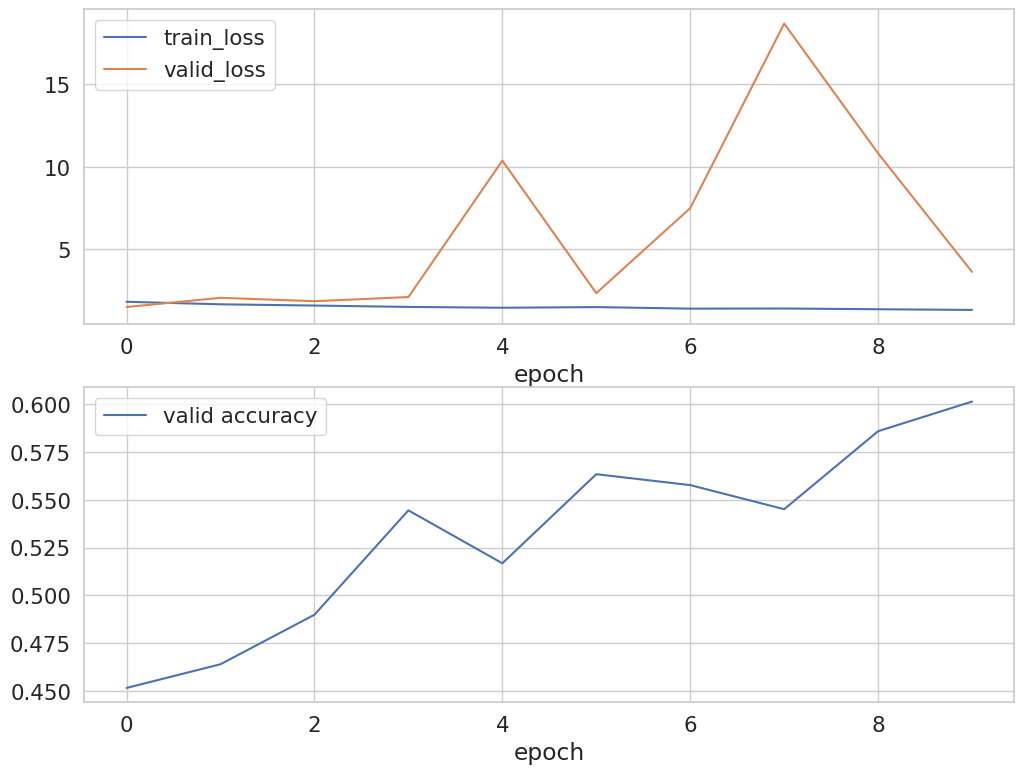

In [ ]:
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_training(*info)

Лосс: 3.6349

Accuracy: 0.6014


Вот что будет, еслиразмер батча равен $1$, тогда $\sigma = 0$, и у нас есть деление на ноль. PyTorch **не умеет обрабатывать такой случай и падает**:

In [ ]:
model = ModelBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

fit(1, model, criterion, optimizer, *get_dataloaders(batch_size=1))


Epoch 1/1


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 120])

Модель маленькая и особых эффектов мы не можем заменить от применения батчнорм

# Dropout

<img src="https://wenkangwei.github.io/images/DL/dropout.jpg" width="1200" height="350">


Дропаут это еще один необычный слой, который используется в нейронных сетях. У него есть один гиперпараметр $p$.

Идея дропаута состоит в том, что во время обучения мы зануляем случайную часть входа и отдаем вход дальше (для каждого числа мы подбрасываем монетку и с вероятностью $p$ зануляем это число).

Дропаут позволяет тренировать более устойчивые сети и избегать переобучения.

### Dropout, механика работы.

Как мы сказали выше, dropout зануляет случайную часть входов и отдает их дальше. Допустим $p=0.5$ (достаточное популярное значение). Тогда мы просто убираем половину всего входа! Такое сильное воздействие явно плохо повлияет на качество нашей модели, поэтому мы делаем зануление только во время обучения.

**Во время обучения**: для каждого числа во входе подбрасываем монетку и зануляем его с вероятностью $p$. Выход умножаем на $\frac{1}{1-p}$, чтобы дисперсия выходов осталось такой же, как и на входе.

**Во время предсказаний**: ничего не делаем).

### Dropout, что дает?

* Сеть выучивает более устойчивые представления на внутренних слоях.
* Сильно увеличивает число итераций, которые нужны для сходимости.
* Можно получить интерпретацию, которая говорит, что дропаут усредняет выходы большо числа нейросетей с $p|W|$ нейронами на предыдущем слоев.

Дропаут вызывает интересный эффект: в начале обучения качество на тестовом датасете выше, чем на обучающем. Потому что для обучающего датасета у нас есть зануление, которое сильно портит предсказания.

### Dropout, взаимодействие с BatchNorm.

Статья, исследующая, почему исопльзование дропаута и батчнорма вместе часто ведет к более плохим результатам, чем их использование по-отдельности - https://arxiv.org/pdf/1801.05134.pdf

Картинка из статьи, объясняющая проблему:
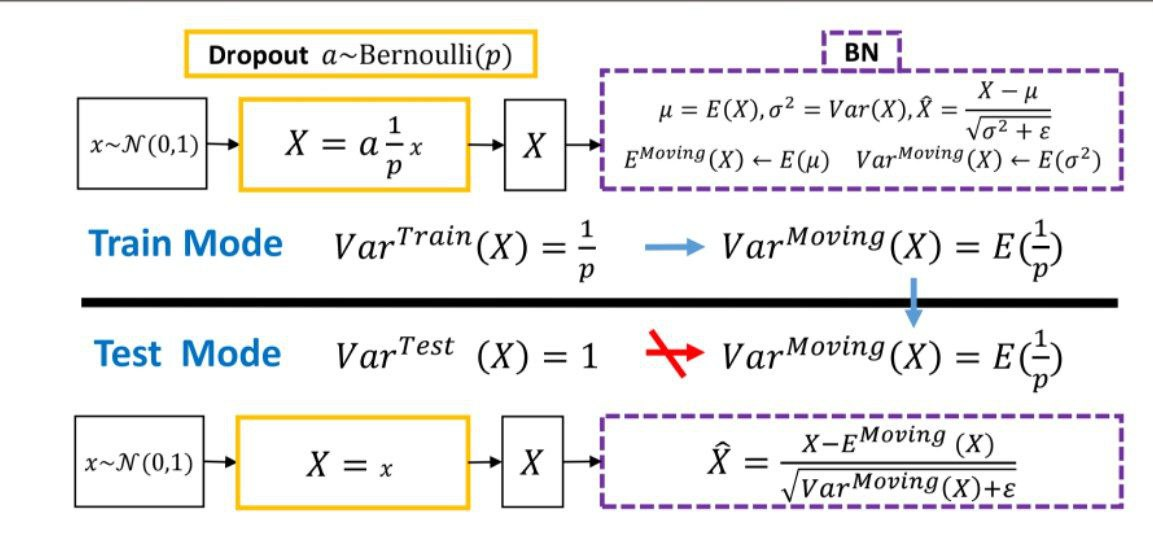

(Если совсем коротко, то при наличии дропаута во время обучения и во время предсказаний выходы дропаута имеют разное распределение. Поэтому статистики, которые batchnorm считает для применения во время предсказаний, оказываются неверными.)

Решение: если вы хотите использовать батчнорм и дропаут в одной сети, то все Dropout"ы должны идти после BatchNorm"ов.

### Dropout, PyTorch

В PyTorch есть `F.dropout(x, p=p)` и слой `nn.Dropout(p=p)`. В чем их отличие? `F.dropout(x, p=p)` не будет изменять свое поведение в заивимости от того, в каком стостянии сейчас модель (train, eval).

Теперь чуть подробнее:

Когда вы вызываете model.train()/model.eval() PyTorch проходится по всем переменным класса и если видит там наследника nn.Module или nn.ModuleList, то также меняет состояние для всех найденных модулей. Т.е. версия со слоем будет автоматически работать с train/eval состяниями.

После сверточных  слоев не принято делать дропаут, т.к. сверточные сети можно представить как полносвязные слои, но с очень разреженными матрицами. И свертка делает линейное преобразование, но с меньшим количеством параметров, то такие слои сами по себе лучше срегуляризированы

In [ ]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 1/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 1.9425 | Val Loss: 1.8362 | Val Acc: 0.3238

Epoch 2/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 1.9348 | Val Loss: 2.0019 | Val Acc: 0.2459

Epoch 3/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 1.9561 | Val Loss: 1.9002 | Val Acc: 0.2983

Epoch 4/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 1.9567 | Val Loss: 2.1573 | Val Acc: 0.2097

Epoch 5/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 1.9686 | Val Loss: 1.9065 | Val Acc: 0.2734

Epoch 6/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 1.9560 | Val Loss: 1.9726 | Val Acc: 0.2537

Epoch 7/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 1.9506 | Val Loss: 1.9226 | Val Acc: 0.2828

Epoch 8/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 1.9664 | Val Loss: 2.0274 | Val Acc: 0.2358

Epoch 9/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 1.9868 | Val Loss: 1.9152 | Val Acc: 0.2664

Epoch 10/10


Training:   0%|          | 0/12500 [00:00<?, ?it/s]

Validation:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 2.0036 | Val Loss: 1.9451 | Val Acc: 0.2647


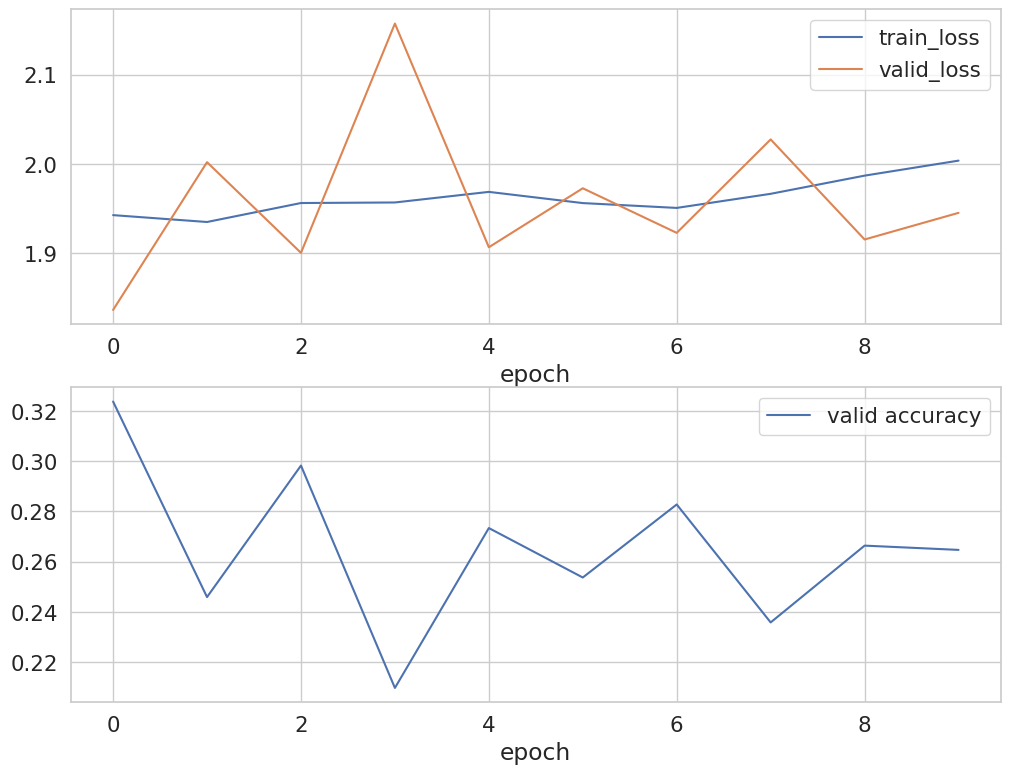

In [ ]:
model = ModelDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_training(*info)

Лосс: 1.9451

Accuracy: 0.2647

Итого мы скорее испортили модель:

*   обычная сетка: 0.6596
*   батчнорм: 0.6014
*   дропаут: 0.2647

Видимо у нас модель маленькая, а такие методы подходят для больших нейросетей, плюс может влиять небольшое количество эпох
